In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import glob
import os
import xgboost as xgb
import dask.array as da
import dask.dataframe as dd
from sklearn.metrics import accuracy_score, confusion_matrix

#bikes data
folder_path = "data_no2020/"
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
df_list = [dd.read_csv(file, assume_missing=True, dtype={'last_reported': 'float64','station_id':'float64','num_docks_available':'float64','is_returning':'float64','ttl':'float64', 'status':'object'}) for file in csv_files]
df_datos_bikes = dd.concat(df_list, ignore_index=True)

#stations info + external sources
stations_info = pd.read_csv('stations_info/stations.csv')
calendar = pd.read_csv('calendar.csv')
metro = pd.read_csv('metro_bcn.csv')

In [2]:
from geopy.distance import geodesic

# Function to calculate the Haversine distance (in meters)
def haversine(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).meters


stations_info['nearest_station_id'] = None
stations_info['nearest_station_distance'] = None
stations_info['stations_within_100m'] = None
stations_info['stations_within_300m'] = None
stations_info['stations_within_500m'] = None

# Iterate over each station to calculate distance to other station
for idx, station in stations_info.iterrows():
    nearest_station = None
    nearest_distance = float('inf')
    count_100m = 0
    count_300m = 0
    count_500m = 0
    
    for jdx, other_station in stations_info.iterrows():
        if station['station_id'] != other_station['station_id']:
            distance = haversine(station['lat'], station['lon'], 
                                 other_station['lat'], other_station['lon'])
            if distance < nearest_distance:
                nearest_station = other_station['station_id']
                nearest_distance = distance
            
            if distance <= 100:
                count_100m += 1
            if distance <= 300:
                count_300m += 1
            if distance <= 500:
                count_500m += 1
    
    # Add into Dataframe
    stations_info.at[idx, 'nearest_station_id'] = nearest_station
    stations_info.at[idx, 'nearest_station_distance'] = nearest_distance
    stations_info.at[idx, 'stations_within_100m'] = count_100m
    stations_info.at[idx, 'stations_within_300m'] = count_300m
    stations_info.at[idx, 'stations_within_500m'] = count_500m

In [3]:
# Haversine formula to calculate the distance in meters
def haversine(lon1, lat1, lon2, lat2):
    # Convert degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Radius of the Earth in meters (mean radius)
    R = 6371000
    distance = R * c
    return distance


# Function to find nearest metro station for each bicycle station
def find_nearest_metro(stations_info, metro):
    nearest_metro_ids = []
    nearest_distances = []

    for _, bike_station in stations_info.iterrows():
        bike_lat = bike_station['lat']
        bike_lon = bike_station['lon']
        
        # Calculate the distance to each metro station and find the minimum
        distances = metro.apply(lambda row: haversine(bike_lon, bike_lat, row['longitude'], row['latitude']), axis=1)
        
        # Find the minimum distance and the corresponding metro station
        nearest_metro_id = metro.loc[distances.idxmin(), 'name']
        nearest_distance = distances.min()
        
        nearest_metro_ids.append(nearest_metro_id)
        nearest_distances.append(nearest_distance)
    
    stations_info['nearest_metro'] = nearest_metro_ids
    stations_info['distance_to_nearest_metro'] = nearest_distances

    return stations_info

# Apply the function
bicycle_stations_metro = find_nearest_metro(stations_info, metro)

In [4]:
#Transformamos en un formato de hora legible
df_datos_bikes["last_reported"] = dd.to_datetime(df_datos_bikes["last_reported"], unit='s')
#Descomponemos el Datatime (last_reported)
df_datos_bikes["year"] = df_datos_bikes["last_reported"].dt.year
df_datos_bikes["month"] = df_datos_bikes["last_reported"].dt.month
df_datos_bikes["day"] = df_datos_bikes["last_reported"].dt.day
df_datos_bikes["hour"] = df_datos_bikes["last_reported"].dt.hour
df_datos_bikes.dropna(subset=['last_reported'])

,station_id,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,last_reported,is_charging_station,status,is_installed,is_renting,is_returning,traffic,last_updated,ttl,V1,year,month,day,hour
npartitions=113,,,,,,,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,datetime64[ns],object,object,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [5]:
df_final = df_datos_bikes.groupby(['station_id', 'year', 'month', 'day', 'hour'])[['num_docks_available','num_bikes_available']].median().round(4).reset_index()
# Asegurar que 'result' es un DataFrame de Pandas
if not isinstance(df_final, pd.DataFrame):
    df_final = df_final.compute() 

/Users/vitaliymachok/anaconda3/lib/python3.11/site-packages/dask/dataframe/io/csv.py:195: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
/Users/vitaliymachok/anaconda3/lib/python3.11/site-packages/dask/dataframe/io/csv.py:195: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
/Users/vitaliymachok/anaconda3/lib/python3.11/site-packages/dask/dataframe/io/csv.py:195: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
/Users/vitaliymachok/anaconda3/lib/python3.11/site-packages/dask/dataframe/io/csv.py:195: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
/Users/vitaliymachok/anaconda3/lib/python3.11/site-packages/dask/dataframe/io/csv.py:195: DtypeWarning: Columns (6) have mix

In [6]:
# Configura la visualización de pandas para mostrar números con 4 decimales
pd.options.display.float_format = '{:,.4f}'.format
df_final = df_final.round(4)

df_final = df_final.loc[df_final['year'] != 1970]
df_final[['station_id','year','month','day','hour']] = df_final[['station_id','year','month','day','hour']].astype(int)
df_final.year.unique()

# Unir los DataFrames usando 'station_id' como clave
merged_df = pd.merge(df_final, stations_info, on="station_id", how="left")

In [7]:
# Tenemos que cambiar capacity al max capacity de la estacion para que nos de como mucho 100% disponibilidad
merged_df['capacity'].fillna(merged_df['num_bikes_available'] + merged_df['num_docks_available'], inplace=True)

merged_df["num_docks_available_mod"] = merged_df['capacity'] - merged_df['num_bikes_available']

# Agregar la columna "percentage_docks_available"
merged_df["percentage_docks_available"] = merged_df["num_docks_available_mod"] / merged_df["capacity"]

# Opcional: llenar valores NaN si hay estaciones sin capacidad registrada
merged_df["percentage_docks_available"].fillna(0, inplace=True)

In [8]:
# Ordenar los datos correctamente antes de agrupar
df_prediction_task = merged_df.sort_values(
    by=['station_id', 'year', 'month', 'day', 'hour']
)

for i in range(1, 5):
    df_prediction_task = df_prediction_task.sort_values(by=['station_id','year', 'month', 'day', 'hour'])  # Ordena correctamente
    df_prediction_task[f'disponibilidad_porcentage_{i}h_antes'] = (
        df_prediction_task.groupby('station_id')['percentage_docks_available']
        .shift(i)  # Desplazamiento de i horas
        .fillna(0)  # Reemplaza NaN con 0
    )


In [9]:
# Ordenar cronológicamente y mostrar solo las columnas importantes
#df_prediction_task = df_prediction_task.sort_values(by=['year', 'month', 'day', 'hour'])

df_prediction_task[['station_id', 'year', 'month', 'day', 'hour', 
                   'percentage_docks_available', 
                   'disponibilidad_porcentage_1h_antes', 
                   'disponibilidad_porcentage_2h_antes', 
                   'disponibilidad_porcentage_3h_antes', 
                   'disponibilidad_porcentage_4h_antes']].head(10)  # Puedes ajustar el número de filas

,station_id,year,month,day,hour,percentage_docks_available,disponibilidad_porcentage_1h_antes,disponibilidad_porcentage_2h_antes,disponibilidad_porcentage_3h_antes,disponibilidad_porcentage_4h_antes
3883759,1,2021,12,31,22,0.6087,0.0000,0.0000,0.0000,0.0000
5365125,1,2021,12,31,23,0.6196,0.6087,0.0000,0.0000,0.0000
5365163,1,2022,1,1,0,0.6957,0.6196,0.6087,0.0000,0.0000
7588905,1,2022,1,1,1,0.7391,0.6957,0.6196,0.6087,0.0000
916079,1,2022,1,1,2,0.7391,0.7391,0.6957,0.6196,0.6087
3883942,1,2022,1,1,3,0.7174,0.7391,0.7391,0.6957,0.6196
2399841,1,2022,1,1,4,0.7174,0.7174,0.7391,0.7391,0.6957
916195,1,2022,1,1,5,0.6739,0.7174,0.7174,0.7391,0.7391
5365371,1,2022,1,1,6,0.6522,0.6739,0.7174,0.7174,0.7391
9813984,1,2022,1,1,7,0.6304,0.6522,0.6739,0.7174,0.7174


In [10]:
# Only getting each 5th row to avoid having repeated data
df_prediction_sorted = df_prediction_task.sort_values(by=['station_id', 'year', 'month', 'day', 'hour']).reset_index(drop=True)
df_prediction_task = df_prediction_sorted.iloc[::5]

percentil_1 = df_prediction_task['nearest_station_distance'].quantile(0.01)
percentil_99 = df_prediction_task['nearest_station_distance'].quantile(0.99)
df_prediction_task['nearest_station_distance_cap']=df_prediction_task['nearest_station_distance'].clip(lower=percentil_1, upper=percentil_99)

df_prediction_task['Date'] = pd.to_datetime(df_prediction_task[['year', 'month', 'day']].astype(str).agg('-'.join, axis=1))
calendar['Date'] = pd.to_datetime(calendar['date'], errors='coerce')

df_prediction_task = df_prediction_task.merge(
    calendar[['Date','special_event']],  # Seleccionamos la columna específica de df_extra
    on='Date',  # Columna común para la fusión
    how='left'  # Realizamos el left join
)

df_prediction_task['special_event'] = df_prediction_task['special_event'].replace({True: 1, False: 0})

# Agregar la columna 'is_weekend' (1 si es sábado o domingo, 0 en otros casos)
df_prediction_task['is_weekend'] = df_prediction_task['Date'].dt.weekday.isin([5, 6]).astype(int)

festivos_data = [
    (2022, 1, 1, "Año Nuevo"),
    (2022, 1, 6, "Reyes Magos"),
    (2022, 4, 15, "Viernes Santo"),
    (2022, 4, 18, "Lunes de Pascua"),
    (2022, 5, 1, "Día del Trabajador"),
    (2022, 6, 6, "Segunda Pascua (festivo local)"),
    (2022, 6, 24, "San Juan"),
    (2022, 8, 15, "La Asunción"),
    (2022, 9, 24, "La Mercè (festivo local)"),
    (2022, 10, 12, "Fiesta Nacional de España"),
    (2022, 11, 1, "Todos los Santos"),
    (2022, 12, 6, "Día de la Constitución"),
    (2022, 12, 8, "La Inmaculada"),
    (2022, 12, 25, "Navidad"),
    (2022, 12, 26, "San Esteban"),

    (2023, 1, 1, "Año Nuevo"),
    (2023, 1, 6, "Reyes Magos"),
    (2023, 4, 7, "Viernes Santo"),
    (2023, 4, 10, "Lunes de Pascua"),
    (2023, 5, 1, "Día del Trabajador"),
    (2023, 5, 29, "Segunda Pascua (festivo local)"),
    (2023, 6, 24, "San Juan"),
    (2023, 8, 15, "La Asunción"),
    (2023, 9, 11, "Diada de Cataluña"),
    (2023, 9, 25, "La Mercè (festivo local)"),
    (2023, 10, 12, "Fiesta Nacional de España"),
    (2023, 11, 1, "Todos los Santos"),
    (2023, 12, 6, "Día de la Constitución"),
    (2023, 12, 8, "La Inmaculada"),
    (2023, 12, 25, "Navidad"),
    (2023, 12, 26, "San Esteban"),

    (2024, 1, 1, "Año Nuevo"),
    (2024, 1, 6, "Reyes Magos"),
    (2024, 3, 29, "Viernes Santo"),
    (2024, 4, 1, "Lunes de Pascua"),
    (2024, 5, 1, "Día del Trabajador"),
    (2024, 5, 20, "Segunda Pascua (festivo local)"),
    (2024, 6, 24, "San Juan"),
    (2024, 8, 15, "La Asunción"),
    (2024, 9, 11, "Diada de Cataluña"),
    (2024, 9, 24, "La Mercè (festivo local)"),
    (2024, 10, 12, "Fiesta Nacional de España"),
    (2024, 11, 1, "Todos los Santos"),
    (2024, 12, 6, "Día de la Constitución"),
    (2024, 12, 8, "La Inmaculada"),
    (2024, 12, 25, "Navidad"),
    (2024, 12, 26, "San Esteban"),
]

# Crear el DataFrame
df_holidays = pd.DataFrame(festivos_data, columns=["year", "month", "day", "name"])

# Crear una nueva columna con la fecha completa en df_festivos
df_holidays["Date"] = pd.to_datetime(df_holidays[["year", "month", "day"]])

# Marcar si la fecha en df_prediction_task es un feriado
df_prediction_task["is_holiday"] = df_prediction_task["Date"].isin(df_holidays["Date"]).astype(int)
# Filling N/As with Most Repeated Value
df_prediction_task.fillna(df_prediction_task.mode().iloc[0], inplace=True)
df_prediction_task['cross_street_mod'] = df_prediction_task['cross_street'].str[:2]
df_prediction_task['Cross_barrio'] = df_prediction_task['cross_street'].str.extract(r'\/(\d+)')

/var/folders/rl/1dvpchx96d9fmfybjz5_9_xw0000gn/T/ipykernel_44714/218570749.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prediction_task['nearest_station_distance_cap']=df_prediction_task['nearest_station_distance'].clip(lower=percentil_1, upper=percentil_99)
/var/folders/rl/1dvpchx96d9fmfybjz5_9_xw0000gn/T/ipykernel_44714/218570749.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prediction_task['Date'] = pd.to_datetime(df_prediction_task[['year', 'month', 'day']].astype(str).agg('-'.join, a

In [11]:
df_prediction_task.columns

Index(['station_id', 'year', 'month', 'day', 'hour', 'num_docks_available',
       'num_bikes_available', 'name', 'physical_configuration', 'lat', 'lon',
       'altitude', 'address', 'cross_street', 'post_code', 'capacity',
       'is_charging_station', 'short_name', 'nearby_distance',
       '_ride_code_support', 'rental_uris', 'is_valet_station',
       'nearest_station_id', 'nearest_station_distance',
       'stations_within_100m', 'stations_within_300m', 'stations_within_500m',
       'nearest_metro', 'distance_to_nearest_metro', 'num_docks_available_mod',
       'percentage_docks_available', 'disponibilidad_porcentage_1h_antes',
       'disponibilidad_porcentage_2h_antes',
       'disponibilidad_porcentage_3h_antes',
       'disponibilidad_porcentage_4h_antes', 'nearest_station_distance_cap',
       'Date', 'special_event', 'is_weekend', 'is_holiday', 'cross_street_mod',
       'Cross_barrio'],
      dtype='object')

In [12]:
test_data_read = pd.read_csv('metadata_sample_submission_2025.csv')
test_data = pd.merge(test_data_read, stations_info, on="station_id", how="left")

test_data['nearest_station_distance_cap']=test_data['nearest_station_distance'].clip(lower=percentil_1, upper=percentil_99)
test_data['Date'] = pd.to_datetime('2025-' + test_data['month'].astype(str).str.zfill(2) + '-' + test_data['day'].astype(str).str.zfill(2))
calendar['Date'] = pd.to_datetime(calendar['date'], errors='coerce')

test_data = test_data.merge(
    calendar[['Date','special_event']],  # Seleccionamos la columna específica de df_extra
    on='Date',  # Columna común para la fusión
    how='left'  # Realizamos el left join
)

test_data['special_event'] = test_data['special_event'].replace({True: 1, False: 0})

# Agregar la columna 'is_weekend' (1 si es sábado o domingo, 0 en otros casos)
test_data['is_weekend'] = test_data['Date'].dt.weekday.isin([5, 6]).astype(int)

# Crear una nueva columna con la fecha completa en df_festivos
df_holidays["Date"] = pd.to_datetime(df_holidays[["year", "month", "day"]])

# Marcar si la fecha en df_prediction_task es un feriado
test_data["is_holiday"] = test_data["Date"].isin(df_holidays["Date"]).astype(int)
# Filling N/As with Most Repeated Value
test_data.fillna(df_prediction_task.mode().iloc[0], inplace=True)
test_data['cross_street_mod'] = test_data['cross_street'].str[:2]
test_data['Cross_barrio'] = test_data['cross_street'].str.extract(r'\/(\d+)')

/var/folders/rl/1dvpchx96d9fmfybjz5_9_xw0000gn/T/ipykernel_44714/1495120890.py:25: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_data.fillna(df_prediction_task.mode().iloc[0], inplace=True)


In [13]:
test_data = test_data.rename(columns={
    'ctx-1': 'disponibilidad_porcentage_1h_antes',
    'ctx-2': 'disponibilidad_porcentage_2h_antes',
    'ctx-3': 'disponibilidad_porcentage_3h_antes',
    'ctx-4': 'disponibilidad_porcentage_4h_antes'
})

In [14]:
test_data.columns

Index(['index', 'station_id', 'month', 'day', 'hour',
       'disponibilidad_porcentage_4h_antes',
       'disponibilidad_porcentage_3h_antes',
       'disponibilidad_porcentage_2h_antes',
       'disponibilidad_porcentage_1h_antes', 'name', 'physical_configuration',
       'lat', 'lon', 'altitude', 'address', 'cross_street', 'post_code',
       'capacity', 'is_charging_station', 'short_name', 'nearby_distance',
       '_ride_code_support', 'rental_uris', 'is_valet_station',
       'nearest_station_id', 'nearest_station_distance',
       'stations_within_100m', 'stations_within_300m', 'stations_within_500m',
       'nearest_metro', 'distance_to_nearest_metro',
       'nearest_station_distance_cap', 'Date', 'special_event', 'is_weekend',
       'is_holiday', 'cross_street_mod', 'Cross_barrio'],
      dtype='object')

Test R-squared: 1.0000
Test Mean Squared Error: 0.0000


<Figure size 1000x800 with 0 Axes>

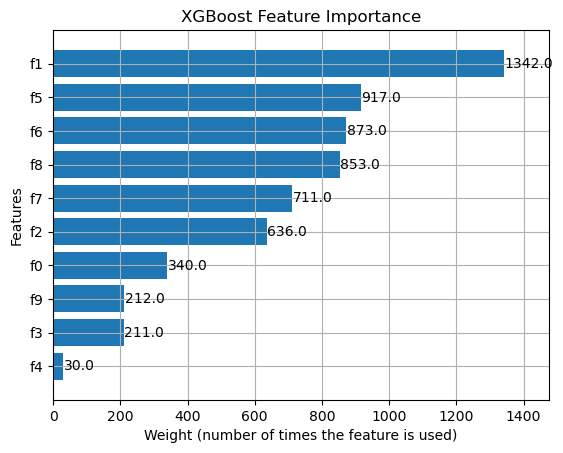

In [15]:
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Define feature columns and target
features = ['month', 'hour', 'capacity', 'is_weekend', 'is_holiday',
           'disponibilidad_porcentage_1h_antes','altitude', #'special_event',
          'disponibilidad_porcentage_2h_antes', 
          # 'disponibilidad_porcentage_3h_antes',
           #'disponibilidad_porcentage_4h_antes', 
            'nearest_station_distance_cap',
            'stations_within_300m']

target_variable = 'percentage_docks_available'

# Drop NA rows in training data
df_prediction_task = df_prediction_task.dropna(subset=features + [target_variable])

# Split into features and target
X_train = df_prediction_task[features]
y_train = df_prediction_task[target_variable]

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Initialize and train model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# --- APPLY TO TEST DATA ---
# Ensure test data has necessary features (and drop NA if needed)
test_data = test_data.dropna(subset=features)
X_test = test_data[features]
X_test_scaled = scaler.transform(X_test)  # Use the same scaler from training

# Make predictions
test_data['percentage_docks_available'] = xgb_model.predict(X_test_scaled)

# --- OPTIONAL: Evaluate if target is available in test_data ---
if target_variable in test_data.columns:
    y_test = test_data[target_variable]
    y_pred = test_data['percentage_docks_available']
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Test R-squared: {r2:.4f}")
    print(f"Test Mean Squared Error: {mse:.4f}")

# --- Feature Importance ---
plt.figure(figsize=(10, 8))
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=10,
                    title='XGBoost Feature Importance', height=0.8,
                    xlabel='Weight (number of times the feature is used)')
plt.show()

In [16]:
import pandas as pd

# Seleccionar las columnas que usarás en el modelo
features_ = ['month', 'day', 'hour',
           'disponibilidad_porcentage_1h_antes',
          'disponibilidad_porcentage_2h_antes',
          'disponibilidad_porcentage_3h_antes',
           'disponibilidad_porcentage_4h_antes']

target = 'percentage_docks_available'

df_check = df_prediction_task[features_ + [target]].copy()

In [17]:
# Eliminar filas vacías
df_check = df_check.dropna(subset=features_ + [target])
df_check.drop_duplicates(inplace=True)

In [18]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Separar X e y
X_raw_train = df_check[features_].values
y_raw_train = df_check[[target]].values

X_raw_test = test_data[features_].values
y_raw_test = test_data[[target]].values

# Split train/test
#split = int(len(X) * 0.8)
#X_raw_train, X_raw_test = X[:split], X[split:]
#y_raw_train, y_raw_test = y[:split], y[split:]

# Escalar
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_raw_train)
X_test_scaled = scaler_X.transform(X_raw_test)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_raw_train)
y_test_scaled = scaler_y.transform(y_raw_test)

# Reshape para LSTM
X_train = X_train_scaled.reshape((X_train_scaled.shape[0], len(features_), 1))
X_test = X_test_scaled.reshape((X_test_scaled.shape[0], len(features_), 1))

In [19]:
# Modelo LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [20]:
model.fit(X_train, y_train_scaled, epochs=10, batch_size=16, validation_split=0.1)

Epoch 1/10
115825/115825 [==============================] - 121s 1ms/step - loss: 0.0044 - val_loss: 0.0025
Epoch 2/10
115825/115825 [==============================] - 135s 1ms/step - loss: 0.0039 - val_loss: 0.0029
Epoch 3/10
115825/115825 [==============================] - 135s 1ms/step - loss: 0.0038 - val_loss: 0.0024
Epoch 4/10
115825/115825 [==============================] - 134s 1ms/step - loss: 0.0038 - val_loss: 0.0025
Epoch 5/10
115825/115825 [==============================] - 135s 1ms/step - loss: 0.0038 - val_loss: 0.0026
Epoch 6/10
115825/115825 [==============================] - 135s 1ms/step - loss: 0.0038 - val_loss: 0.0024
Epoch 7/10
115825/115825 [==============================] - 152s 1ms/step - loss: 0.0038 - val_loss: 0.0024
Epoch 8/10
115825/115825 [==============================] - 134s 1ms/step - loss: 0.0038 - val_loss: 0.0024
Epoch 9/10
115825/115825 [==============================] - 134s 1ms/step - loss: 0.0037 - val_loss: 0.0024
Epoch 10/10
115825/115825 [=

In [21]:
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

12548/12548 [==============================] - 5s 374us/step


In [29]:
results_df = pd.DataFrame(y_pred, columns=["percentage_docks_available"])
results_df.reset_index().to_csv('submission_new_lstm_simple_final.csv', index=False)

In [40]:
# Features
sequence_features = [
    'disponibilidad_porcentage_4h_antes',
    'disponibilidad_porcentage_3h_antes',
    'disponibilidad_porcentage_2h_antes',
    'disponibilidad_porcentage_1h_antes'
]
context_features = ['month', 'day', 'hour', 'capacity', 'is_weekend', 
                    'is_holiday','altitude', 'post_code','cross_street_mod',
                    'Cross_barrio','post_code', 'nearest_station_distance_cap', 'stations_within_300m']
target = 'percentage_docks_available'

In [42]:
df_new = df_prediction_task[sequence_features + context_features + [target]].copy()

In [43]:
df_test_new = test_data[sequence_features + context_features + [target]].copy()

In [45]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate


# Separar X e y
X_seq = df_new[sequence_features].values
X_ctx = df_new[context_features].values
y = df_new[[target]].values



X_seq_train = df_new[sequence_features].values
X_ctx_train = df_new[context_features].values

X_seq_test = df_test_new[sequence_features].values
X_ctx_test = df_test_new[context_features].values

y_train = df_new[[target]].values



# Split train/test
#split = int(len(df) * 0.8)
#X_seq_train, X_seq_test = X_seq[:split], X_seq[split:]
#X_ctx_train, X_ctx_test = X_ctx[:split], X_ctx[split:]
#y_train, y_test = y[:split], y[split:]

# Escalar
scaler_seq = MinMaxScaler()
scaler_ctx = MinMaxScaler()
scaler_y = MinMaxScaler()

X_seq_train_scaled = scaler_seq.fit_transform(X_seq_train).reshape((-1, 4, 1))
X_seq_test_scaled = scaler_seq.transform(X_seq_test).reshape((-1, 4, 1))

X_ctx_train_scaled = scaler_ctx.fit_transform(X_ctx_train)
X_ctx_test_scaled = scaler_ctx.transform(X_ctx_test)

y_train_scaled = scaler_y.fit_transform(y_train)
#y_test_scaled = scaler_y.transform(y_test)

In [46]:

# Modelo
input_seq = Input(shape=(4, 1), name="secuencia")
lstm_out = LSTM(50, activation='relu')(input_seq)

input_ctx = Input(shape=(X_ctx_train_scaled.shape[1],), name="contexto")

merged = Concatenate()([lstm_out, input_ctx])
output = Dense(1)(merged)

model = Model(inputs=[input_seq, input_ctx], outputs=output)
model.compile(optimizer='adam', loss='mse')

In [47]:
# Entrenamiento
model.fit(
    {'secuencia': X_seq_train_scaled, 'contexto': X_ctx_train_scaled},
    y_train_scaled,
    epochs=10,
    batch_size=16,
    validation_split=0.1,
    verbose=1
)

Epoch 1/10
116770/116770 [==============================] - 90s 766us/step - loss: 0.0041 - val_loss: 0.0024
Epoch 2/10
116770/116770 [==============================] - 92s 785us/step - loss: 0.0039 - val_loss: 0.0025
Epoch 3/10
116770/116770 [==============================] - 89s 764us/step - loss: 0.0038 - val_loss: 0.0024
Epoch 4/10
116770/116770 [==============================] - 93s 793us/step - loss: 0.0038 - val_loss: 0.0025
Epoch 5/10
116770/116770 [==============================] - 90s 774us/step - loss: 0.0038 - val_loss: 0.0025
Epoch 6/10
116770/116770 [==============================] - 90s 768us/step - loss: 0.0038 - val_loss: 0.0025
Epoch 7/10
116770/116770 [==============================] - 89s 761us/step - loss: 0.0038 - val_loss: 0.0024
Epoch 8/10
116770/116770 [==============================] - 89s 764us/step - loss: 0.0038 - val_loss: 0.0024
Epoch 9/10
116770/116770 [==============================] - 80s 688us/step - loss: 0.0038 - val_loss: 0.0024
Epoch 10/10
116770/

In [48]:
# Predicción y evaluación
y_pred_scaled = model.predict({'secuencia': X_seq_test_scaled, 'contexto': X_ctx_test_scaled})
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test_scaled)

12548/12548 [==============================] - 4s 325us/step


In [49]:
results_df = pd.DataFrame(y_pred, columns=["percentage_docks_available"])
results_df.reset_index().to_csv('submission_lstm_crazy_final.csv', index=False)